# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [135]:
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az
import xarray as xr


df = pd.read_csv("data_stats_filtered.csv", index_col=0)
df["region_name_id"] = pd.factorize(df["region_name"])[0]
print(f"N = {df.shape[0]}")
df.sample(5)

N = 3228


,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,upper_cap,gdp_per_capita,inclusive,restricted,region_name_id
1084,1385,Italy,7.4500,338.923802,297.952159,381.000715,45.50,6.094989,39.942379,45.432341,51.070263,2703,1,1,4
1022,1323,Italy,9.3100,197.284977,167.118471,229.197505,33.60,3.596563,17.861980,21.085718,24.495895,2588,1,1,4
1253,1554,Italy,11.0800,3420.232372,3127.018557,3735.642489,261.80,23.635065,282.382282,308.863969,337.348738,2419,1,1,4
2194,1455,Nordic countries,1.2350,60.231418,42.363531,81.137267,4.75,3.909848,34.904772,49.630402,66.860069,1436,1,1,7
2245,1506,Nordic countries,1.4774,145.243074,108.089121,186.947440,12.40,8.413112,73.435056,98.681269,127.019388,1980,1,1,7


We have GDP data for the following 10 regions:

In [136]:
df["region_name"].value_counts()

United Kingdom      590
Nordic countries    541
France              532
Italy               532
Low countries       487
Eastern Europe      423
Spain                58
Chinese world        46
Japan                12
German world          7
Name: region_name, dtype: int64

We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

In [137]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(1 + df["score"])
df["score_cap_log"] = np.log(1 + df["score_cap"])
df["N_est_log"] = np.log(1 + df["N_est"])
df["N_est_cap_log"] = np.log(1 + df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(1 + df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df.sample(5)

,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,...,score_log,score_cap_log,N_est_log,N_est_cap_log,score_log_std,score_cap_log_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std
801,1611,France,19.0500,1825.781270,1674.437932,1984.577714,200.8,10.534278,87.820674,95.759407,...,5.307277,2.445323,7.510311,4.572228,1.210871,0.900873,1.109711,0.935406,7.404888,0.985953
1681,1477,Low countries,1.9775,206.263878,175.299865,239.693984,34.3,17.272727,88.402266,104.025409,...,3.563883,2.905410,5.333993,4.654202,0.813110,1.090064,0.788142,0.952383,7.763446,1.033694
2114,1375,Nordic countries,1.0875,6.392295,4.027195,9.122778,1.0,0.921857,3.721205,5.902306,...,0.693147,0.653292,2.000438,1.931856,0.158144,-0.031130,0.295581,0.364034,7.351158,0.978799
2121,1382,Nordic countries,1.0518,6.535422,4.160752,9.268534,1.0,0.951120,3.959100,6.217745,...,0.693147,0.668403,2.019615,1.976543,0.158144,-0.019174,0.298415,0.374710,7.354362,0.979225
2822,1435,United Kingdom,3.3725,120.682052,94.185171,150.314162,9.0,2.681587,28.008464,35.891474,...,2.302585,1.303344,4.801412,3.607980,0.525341,0.377396,0.709449,0.734182,7.392648,0.984323


The distribution of the logged GDP values is clearly trimodal:

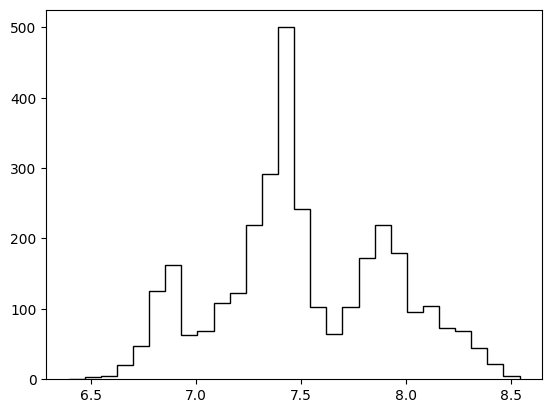

In [138]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

We observe an intriguing trimodal structure. It was suggested by Charles that this might be due to "the fact that the Maddison data always tend to have an estimation for a region at date year=1 and then jump up to over year=1000". Filtering these instances, doesn't seem to alter the trimodal structure, however:

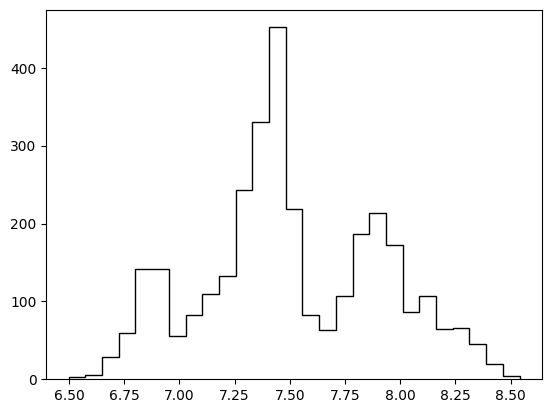

In [139]:
plt.hist(df.loc[df["year"] >= 1000, "log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

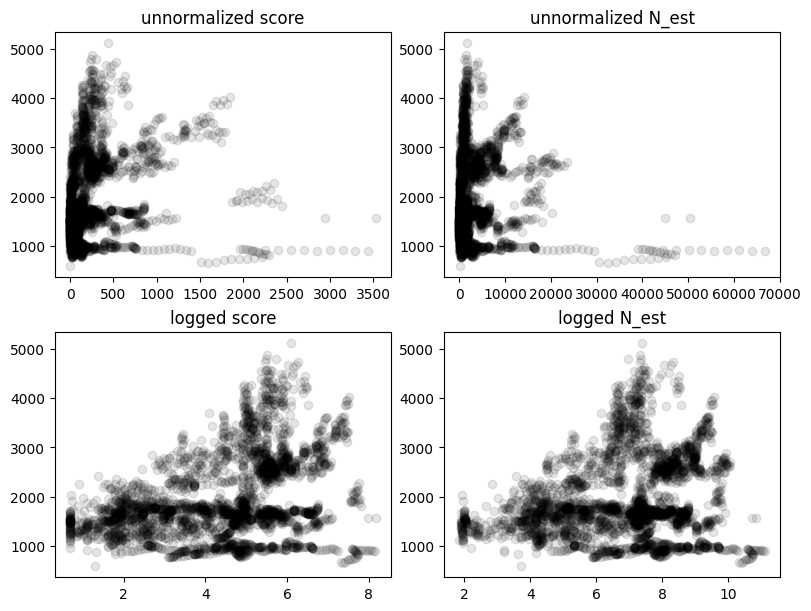

In [140]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [169]:
models = {}

In [142]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)


The model graph looks as follows:

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [143]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 275 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.959,0.020,0.920,0.998,0.000,0.0,2451.0,3271.0,1.0
score_log_std,0.023,0.020,-0.015,0.060,0.000,0.0,2403.0,3058.0,1.0
log_gdp_std_sigma,0.017,0.000,0.017,0.017,0.000,0.0,9724.0,5197.0,1.0
1|region_name_sigma,0.062,0.019,0.035,0.096,0.000,0.0,3217.0,4178.0,1.0
score_log_std|region_name_sigma,0.059,0.018,0.031,0.091,0.000,0.0,2804.0,3609.0,1.0
1|region_name[Chinese world],0.025,0.022,-0.017,0.068,0.000,0.0,2825.0,3908.0,1.0
1|region_name[Eastern Europe],-0.041,0.021,-0.082,-0.003,0.000,0.0,2460.0,3504.0,1.0
1|region_name[France],0.027,0.021,-0.013,0.066,0.000,0.0,2452.0,3255.0,1.0
1|region_name[German world],0.000,0.039,-0.073,0.075,0.001,0.0,5619.0,5331.0,1.0
1|region_name[Italy],0.105,0.021,0.066,0.145,0.000,0.0,2565.0,3444.0,1.0


Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

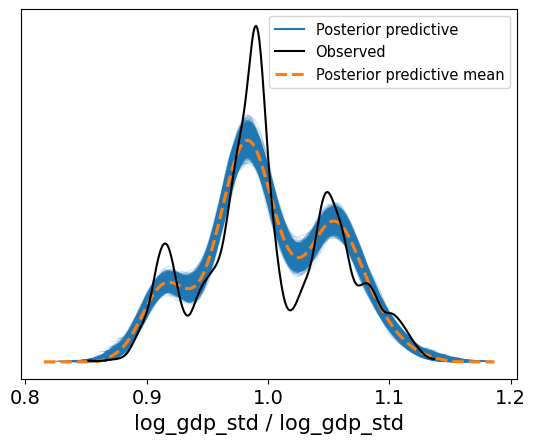

In [145]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

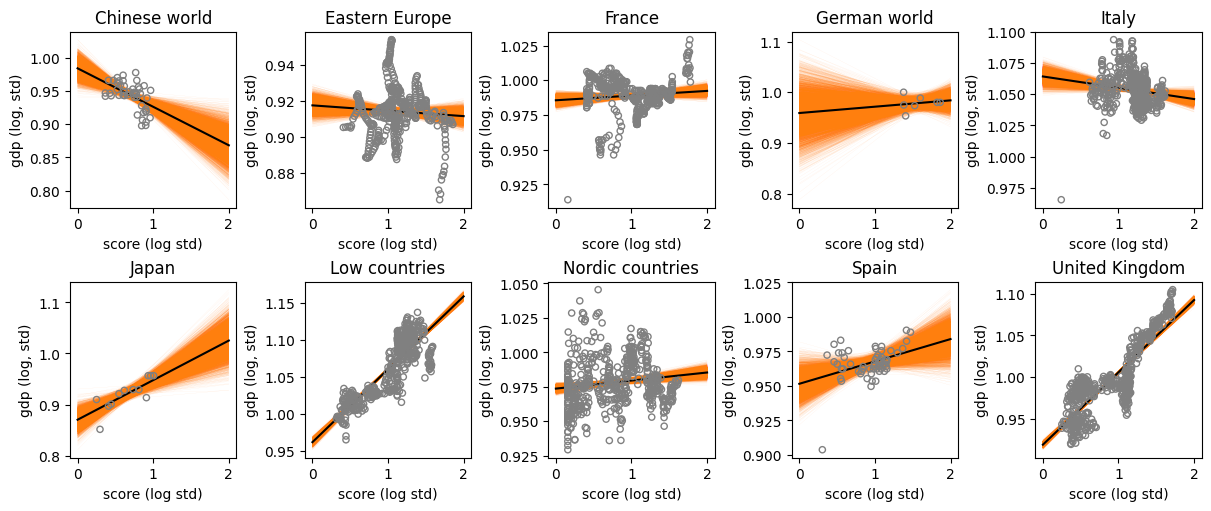

In [146]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

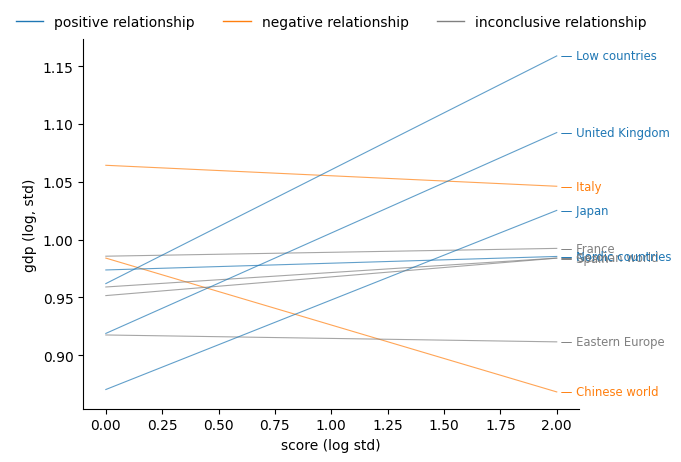

In [147]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

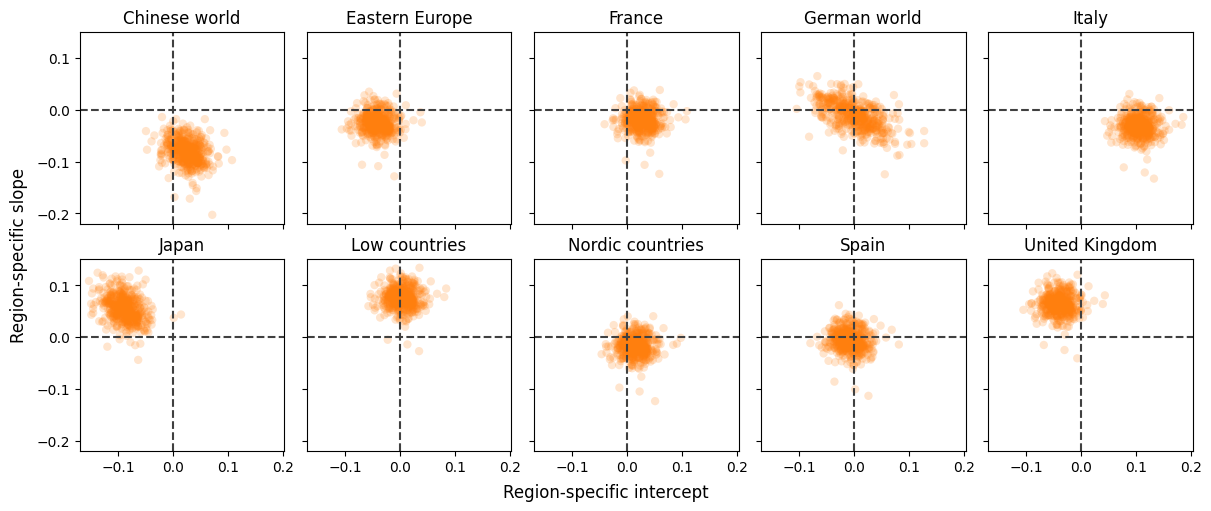

In [148]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [149]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

       Formula: log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [150]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit
az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 400 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.944,0.027,0.894,0.998,0.001,0.000,2135.0,3199.0,1.0
N_est_log_std,0.037,0.029,-0.014,0.094,0.001,0.000,2078.0,2709.0,1.0
log_gdp_std_sigma,0.018,0.000,0.017,0.018,0.000,0.000,10042.0,5091.0,1.0
1|region_name_sigma,0.079,0.024,0.042,0.122,0.000,0.000,2875.0,4171.0,1.0
N_est_log_std|region_name_sigma,0.085,0.025,0.045,0.129,0.000,0.000,3321.0,4155.0,1.0
1|region_name[Chinese world],0.044,0.029,-0.012,0.098,0.001,0.000,2446.0,3554.0,1.0
1|region_name[Eastern Europe],-0.026,0.028,-0.082,0.024,0.001,0.000,2221.0,3227.0,1.0
1|region_name[France],0.040,0.028,-0.014,0.091,0.001,0.000,2149.0,3242.0,1.0
1|region_name[German world],-0.002,0.059,-0.113,0.111,0.001,0.001,6597.0,4949.0,1.0
1|region_name[Italy],0.126,0.028,0.072,0.178,0.001,0.000,2211.0,3279.0,1.0


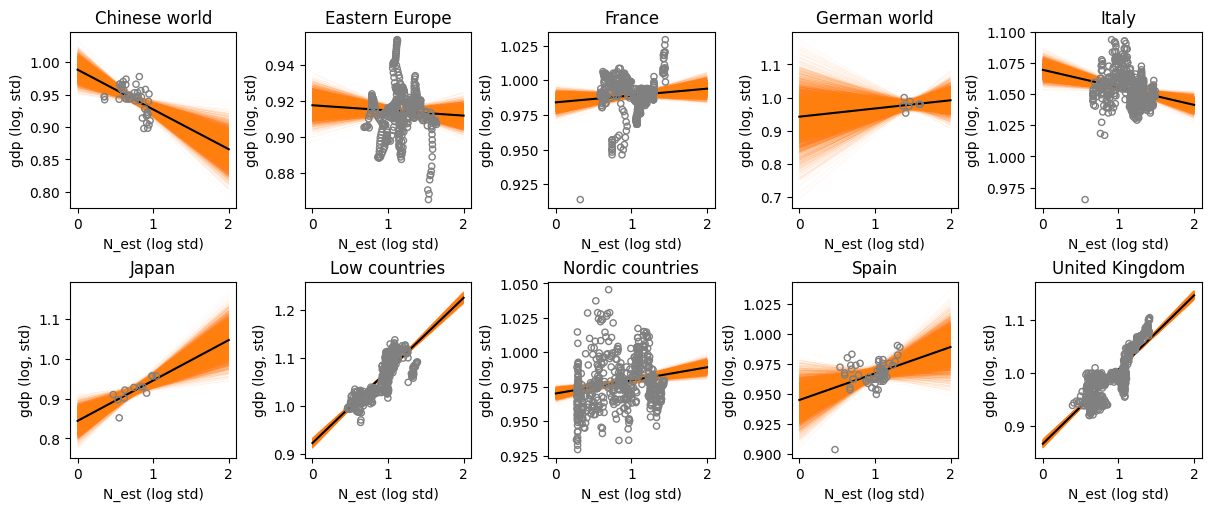

In [151]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

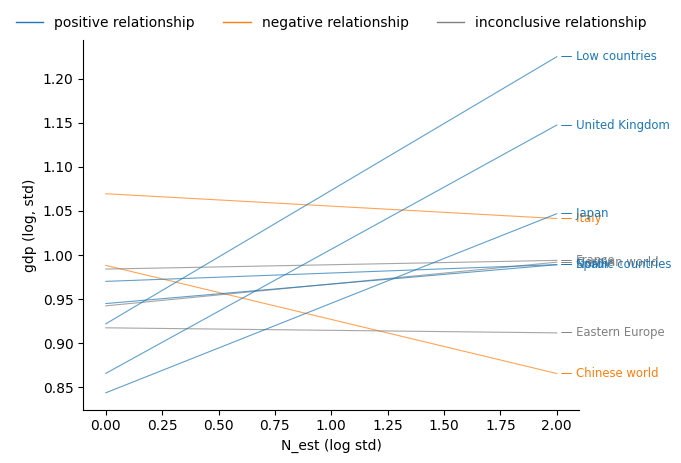

In [152]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [153]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
log_gdp_std ~ score_log_std + (score_log_std|region_name),0,8568.004733,22.105951,0.000000,1.0,49.336144,0.000000,False,log
log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name),1,8415.957439,21.618121,152.047294,0.0,49.515455,11.935312,False,log


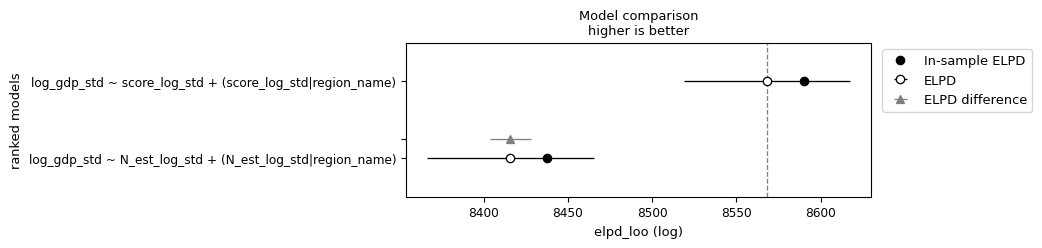

In [154]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

## Top 50% Global

In [155]:
df_top_50 = pd.read_csv("data_stats_filtered_top_50.csv", index_col=0)
df_top_50["region_name_id"] = pd.factorize(df_top_50["region_name"])[0]
print(f"N = {df_top_50.shape[0]}")
df_top_50.sample(5)

N = 3228


,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,upper_cap,gdp_per_capita,inclusive,restricted,region_name_id
1343,1644,Italy,11.1200,4096.801217,3747.961599,4451.152829,148.4,13.337013,337.324041,368.723700,400.618129,2665,1,1,4
2565,1826,Nordic countries,4.3378,11782.591044,10838.290043,12777.966703,354.6,82.212570,2508.592531,2726.906704,2956.953239,1532,1,1,7
1072,1373,Italy,7.8100,230.684283,201.831820,260.651276,28.2,3.626582,26.032341,29.752521,33.615690,2481,1,1,4
1572,1368,Low countries,1.6080,30.265157,21.486543,40.662952,3.6,2.247233,13.396240,18.867352,25.347730,1892,1,1,6
2560,1821,Nordic countries,4.1863,12727.700794,11737.005676,13762.340248,401.6,96.113067,2807.565551,3044.459335,3291.833993,1457,1,1,7


[MODIFICATION CHARLES] no.log(1+x) en raison des valeurs négatives

In [156]:
# Apply normalization
df_top_50["century"] = df_top_50["year"].round(-2)

df_top_50["score_log"] = np.log(1 + df_top_50["score"])
df_top_50["score_cap_log"] = np.log(1 + df_top_50["score_cap"])

df_top_50["N_est_log"] = np.log(1 + df_top_50["N_est"])
df_top_50["N_est_cap_log"] = np.log(1 + df_top_50["N_est_cap"])

df_top_50["score_log_std"] = df_top_50["score_log"] / df_top_50["score_log"].mean()
df_top_50["score_cap_log_std"] = np.log(df_top_50["score_cap_log"]) / df_top_50["score_cap_log"].mean()

df_top_50["N_est_log_std"] = df_top_50["N_est_log"] / df_top_50["N_est_log"].mean()
df_top_50["N_est_cap_log_std"] = np.log(df_top_50["N_est_cap"]) / df_top_50["N_est_cap_log"].mean()

df_top_50["log_gdp"] = np.log(1 + df_top_50["gdp_per_capita"])
df_top_50["log_gdp_std"] = df_top_50["log_gdp"] / df_top_50["log_gdp"].mean()
df_top_50.sample(5)

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,...,score_log,score_cap_log,N_est_log,N_est_cap_log,score_log_std,score_cap_log_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std
2136,1397,Nordic countries,0.9753,36.206211,23.696944,50.601094,1.7,1.755069,24.615861,37.608830,...,0.993252,1.013443,3.616476,3.653481,0.255819,0.006137,0.534364,0.743766,7.329750,0.975948
381,1743,Eastern Europe,20.6900,9078.623313,8211.067149,9988.005086,186.8,9.036721,396.952332,438.909102,...,5.235378,2.306250,9.113788,6.086568,1.348407,0.384052,1.346638,1.247585,6.907755,0.919760
2420,1681,Nordic countries,2.2360,1805.949324,1572.714168,2058.325864,51.2,22.918519,703.806265,808.187936,...,3.955082,3.174653,7.499395,6.696031,1.018658,0.530929,1.108098,1.372768,7.524561,1.001887
1664,1460,Low countries,1.8500,220.132207,183.461721,260.677447,20.0,10.810811,99.168498,118.990382,...,3.044522,2.469015,5.398761,4.787412,0.784137,0.415395,0.797712,0.979943,7.750615,1.031986
3154,1767,United Kingdom,8.4400,4479.151571,4198.470913,4770.598349,380.7,45.214745,498.618242,531.979452,...,5.944635,3.833299,8.407412,6.278483,1.531081,0.617576,1.242265,1.287019,7.969704,1.061157


In [157]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

In [158]:
#df_top_50[df_top_50['score_log_std'].isna()]

In [159]:
m_score_vs_top_50 = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df_top_50, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

In [160]:
m_score_vs_top_50_fit = m_score_vs_top_50.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 245 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

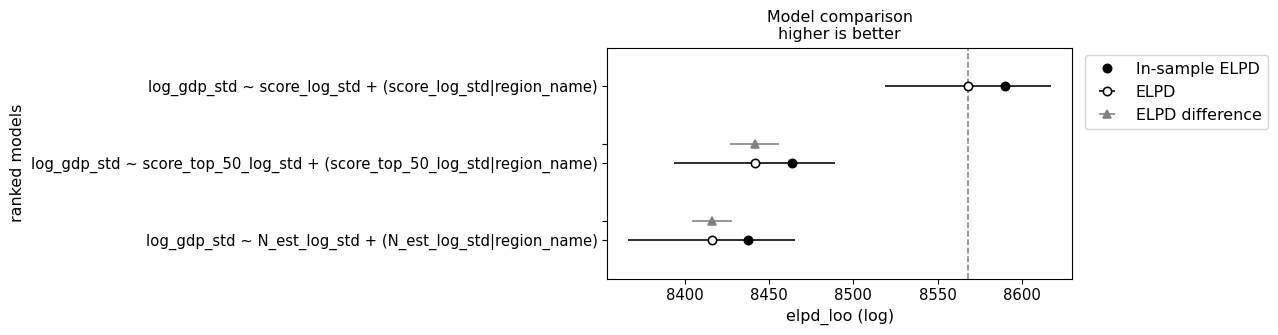

In [161]:
models["log_gdp_std ~ score_top_50_log_std + (score_top_50_log_std|region_name)"] = m_score_vs_top_50_fit
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)

## Top 10% Global

In [162]:
df_top_10 = pd.read_csv("data_stats_filtered_top_10.csv", index_col=0)
df_top_10["region_name_id"] = pd.factorize(df_top_10["region_name"])[0]
print(f"N = {df_top_10.shape[0]}")
df_top_10.sample(5)

# Apply normalization

df_top_10["century"] = df_top_10["year"].round(-2)
df_top_10["score_log"] = np.log(1 + df_top_10["score"])
df_top_10["score_cap_log"] = np.log(1 + df_top_10["score_cap"])
df_top_10["N_est_log"] = np.log(1 + df_top_10["N_est"])
df_top_10["N_est_cap_log"] = np.log(1 + df_top_10["N_est_cap"])
df_top_10["score_log_std"] = df_top_10["score_log"] / df_top_10["score_log"].mean()
df_top_10["score_cap_log_std"] = np.log(df_top_10["score_cap"]) / df_top_10["score_cap_log"].mean()
df_top_10["N_est_log_std"] = df_top_10["N_est_log"] / df_top_10["N_est_log"].mean()
df_top_10["N_est_cap_log_std"] = np.log(df_top_10["N_est_cap"]) / df_top_10["N_est_cap_log"].mean()
df_top_10["log_gdp"] = np.log(1 + df_top_10["gdp_per_capita"])
df_top_10["log_gdp_std"] = df_top_10["log_gdp"] / df_top_10["log_gdp"].mean()
df_top_10.sample(5)

N = 3228


/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,...,score_log,score_cap_log,N_est_log,N_est_cap_log,score_log_std,score_cap_log_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std
3182,1795,United Kingdom,10.4000,8027.367500,7627.254204,8439.520648,162.0,15.536272,728.652768,766.937929,...,5.093750,2.805556,8.990736,6.643709,1.883587,2.220676,1.328456,1.362026,8.073403,1.074965
2322,1583,Nordic countries,1.7007,457.572632,367.522558,556.108678,3.0,1.764087,216.181990,269.159916,...,1.386294,1.016710,6.128119,5.599014,0.512629,0.459514,0.905481,1.147318,7.358194,0.979735
412,1774,Eastern Europe,25.0900,12492.230512,11490.753402,13540.547343,38.2,1.519164,455.143279,494.863876,...,3.668677,0.923927,9.432942,6.206301,1.356618,0.338512,1.393796,1.272189,6.890609,0.917477
2806,1419,United Kingdom,3.1565,50.519124,38.673154,63.906206,1.9,0.600772,12.298160,16.066385,...,1.064711,0.470486,3.941953,2.837111,0.393713,-0.412486,0.582456,0.569369,7.507690,0.999641
2828,1441,United Kingdom,3.4535,113.822164,89.462667,140.549445,0.0,0.000000,25.838776,32.875939,...,0.000000,0.000000,4.743385,3.522705,0.000000,-inf,0.700875,0.716187,7.271704,0.968219


In [163]:
df_top_10[df_top_10['region_name']=='Japan']

,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,...,score_log,score_cap_log,N_est_log,N_est_cap_log,score_log_std,score_cap_log_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std
1540,730,Japan,6.304,40.434486,24.523522,59.497587,0.0,0.000000,3.909733,6.445378,...,0.000000,0.000000,3.724114,2.007594,0.000000,-inf,0.550269,0.382083,6.395262,0.851522
1541,1000,Japan,5.225,68.363752,47.566587,92.849420,0.0,0.000000,9.103653,13.083972,...,0.000000,0.000000,4.239364,2.645037,0.000000,-inf,0.626401,0.527263,6.918695,0.921217
1542,1120,Japan,4.325,23.202893,16.749843,30.549259,0.0,0.000000,3.872796,5.364831,...,0.000000,0.000000,3.186472,1.850788,0.000000,-inf,0.470828,0.344456,6.833032,0.909811
1543,1280,Japan,5.920,36.021126,24.332309,49.428841,1.0,0.168919,4.110187,6.084650,...,0.693147,0.156079,3.611489,1.957930,0.256315,-1.439611,0.533628,0.370273,6.735780,0.896862
1544,1450,Japan,10.500,63.973745,44.114076,85.776312,0.0,0.000000,4.201341,6.092738,...,0.000000,0.000000,4.173983,1.959071,0.000000,-inf,0.616741,0.370546,6.766192,0.900911
1545,1600,Japan,17.000,152.009020,115.203916,193.310065,0.0,0.000000,6.776701,8.941707,...,0.000000,0.000000,5.030497,2.296739,0.000000,-inf,0.743298,0.449209,6.967909,0.927769
1546,1700,Japan,31.300,275.605277,216.798328,339.626030,0.0,0.000000,6.926464,8.805280,...,0.000000,0.000000,5.622591,2.282921,0.000000,-inf,0.830785,0.446056,6.979145,0.929265
1547,1721,Japan,31.174,337.979176,267.463788,413.585346,4.1,0.131525,8.579525,10.841461,...,1.629241,0.123567,5.825939,2.471607,0.602467,-1.642170,0.860831,0.488712,6.979145,0.929265
1548,1750,Japan,31.000,480.745753,387.852620,579.180608,4.0,0.129032,12.511375,15.507928,...,1.609438,0.121361,6.177416,2.803841,0.595144,-1.657662,0.912765,0.562114,6.860664,0.913490
1549,1800,Japan,30.700,792.046935,662.566314,933.433501,2.0,0.065147,21.581965,25.799574,...,1.098612,0.063112,6.675882,3.288386,0.406249,-2.210911,0.986417,0.666486,7.183871,0.956524


In [165]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}


m_score_vs_top_10 = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df_top_10, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

m_score_vs_top_10_fit = m_score_vs_top_10.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 174 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [166]:
models["log_gdp_std ~ score_top_10_log_std + (score_top_10_log_std|region_name)"] = m_score_vs_top_10_fit

<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

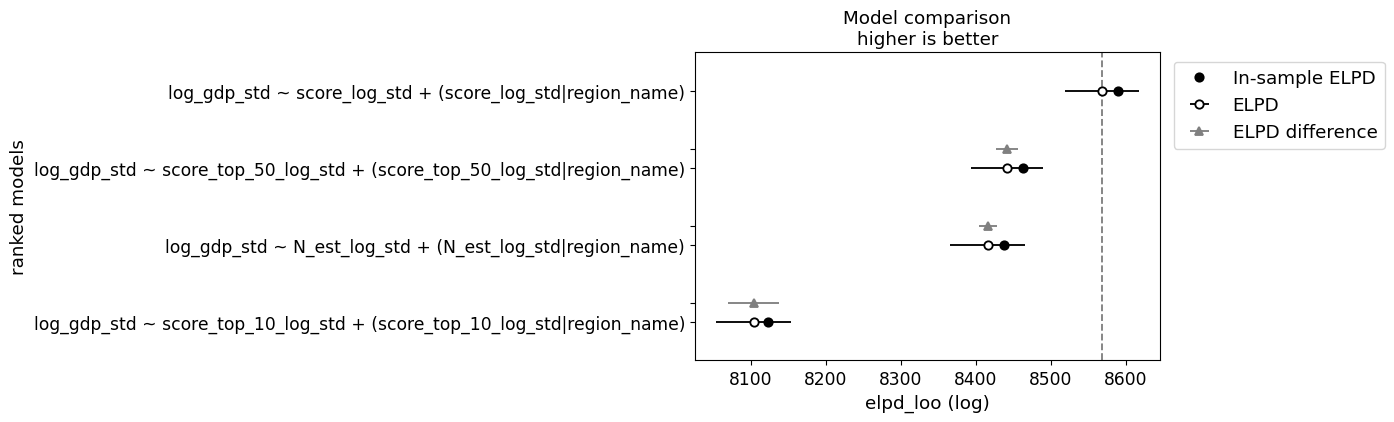

In [168]:
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)